In [392]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from pprint import pprint
import seaborn as sns

In [393]:
df = pd.read_csv('data/preprocessed_commercial_area.csv')

In [394]:
df['2022 소득분위'] = df['2022 소득분위'].apply(lambda x:int(x[0]))

In [397]:
# ['음식점','카페','프랜차이즈','호프']
tmp = pd.DataFrame()
for category in ('음식점','카페','일반학원','병원','오락서비스','마트','음식소매','의류소매','유동인구','소득'):
#     category = '음식점'
    if category == '일반학원' or category == '병원':
        k = 2
    else:
        k = 3


    if category == '음식점':
        df2 = df[[column for column in df.columns if any(category in column for category in ('한식','중식','일식','양식'))]].copy()
    elif category == '카페':
        df2 = df[[column for column in df.columns if any(category in column for category in ('제과점','커피-음료'))]].copy()
    elif category == '일반학원':
        df2 = df[[column for column in df.columns if any(category in column for category in ('일반교습학원','외국어학원','독서실'))]].copy()
    elif category == '병원':
        df2 = df[[column for column in df.columns if any(category in column for category in ('일반의원','치과의원','한의원','동물병원'))]].copy()
    elif category == '오락서비스':
        df2 = df[[column for column in df.columns if any(category in column for category in ('당구장','골프연습장','볼링장','PC방','전자게임장','기타오락장','노래방','DVD방'))]].copy()
    elif category == '마트':
        df2 = df[[column for column in df.columns if any(category in column for category in ('슈퍼마켓','편의점'))]].copy()
    elif category == '음식소매':
        df2 = df[[column for column in df.columns if any(category in column for category in ('주류도매','미곡판매','육류판매','수산물판매','청과상','반찬가게'))]].copy()
    elif category == '의류소매':
        df2 = df[[column for column in df.columns if any(category in column for category in ('일반의류','한복점','유아의류','신발','가방','안경','시계및귀금속'))]].copy()
    elif category == '유동인구':
        df2 = df[[column for column in df.columns if category in column]].copy()
    elif category == '소득':
        df2 = df[[column for column in df.columns if category in column]].copy()
#     common = df[[column for column in df.columns if not any(category in column for category in ('외식업','서비스업','소매업'))]].copy()
    common = df[['시군구','행정구역']].copy()
    df2 = pd.concat([common,df2],axis=1)
    df[['시군구','행정구역']]
    # 결측치
    df2.fillna(0,inplace=True)
    df2 = df2.apply(lambda x:x.replace(float('inf'),0))

    # kmeans clustering
    scaler = StandardScaler()
    scaled_df = pd.DataFrame(scaler.fit_transform(df2.iloc[:,2:]))
    kmeans = KMeans(n_clusters=k,n_init=10 ,random_state=99)
    kmeans.fit(scaled_df)
    df3 = df2.copy()
    df3['label'] = kmeans.labels_

    ranked = df3.iloc[:,2:].groupby(['label']).mean().rank().T
    
    tmp[category] = df3['label'].rename(category)

merged = pd.concat([common,tmp],axis=1)



In [398]:
merged

,시군구,행정구역,음식점,카페,일반학원,병원,오락서비스,마트,음식소매,의류소매,유동인구,소득
0,종로구,청운효자동,1,2,1,0,2,0,2,2,0,1
1,종로구,사직동,0,2,1,1,1,2,1,2,0,1
2,종로구,삼청동,1,2,1,0,2,1,2,2,0,2
3,종로구,부암동,1,0,1,0,2,0,2,1,0,2
4,종로구,평창동,1,0,1,0,2,1,2,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
419,강동구,성내2동,2,2,1,0,1,2,0,1,2,0
420,강동구,성내3동,2,2,0,1,1,2,0,2,2,0
421,강동구,길동,2,2,0,1,0,2,0,2,2,0
422,강동구,둔촌1동,1,0,1,0,2,1,2,1,0,2


# Find Optimal K (silhouette score)

In [290]:
def visualize_silhouette_layer(data,n_init=10):
    clusters_range = range(3,10)
    results = []

    for i in clusters_range:
        clusterer = KMeans(n_clusters=i,n_init=n_init,random_state=0)
        cluster_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

    plt.figure()
    sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm._rocket_lut)
    plt.tight_layout()
    plt.show()

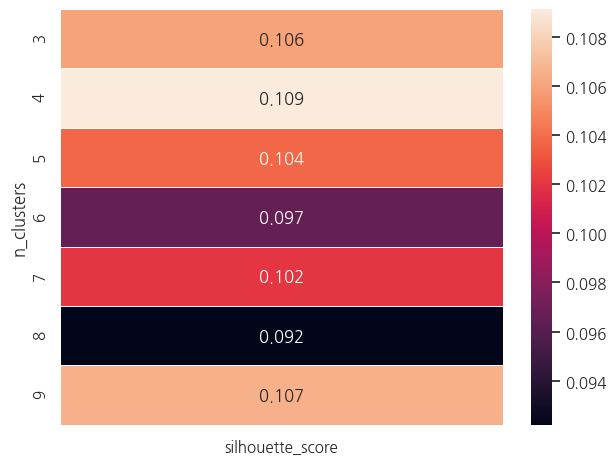

In [291]:
visualize_silhouette_layer(scaled_df)

In [292]:
kmeans = KMeans(n_clusters=9,n_init=10)
kmeans.fit(scaled_df)
df3 = df2.copy()
df3['label'] = kmeans.labels_

In [294]:
mean = df3.iloc[:,2:].groupby(['label']).mean().T

In [296]:
mean = mean.div(mean.max(axis=1), axis=0)

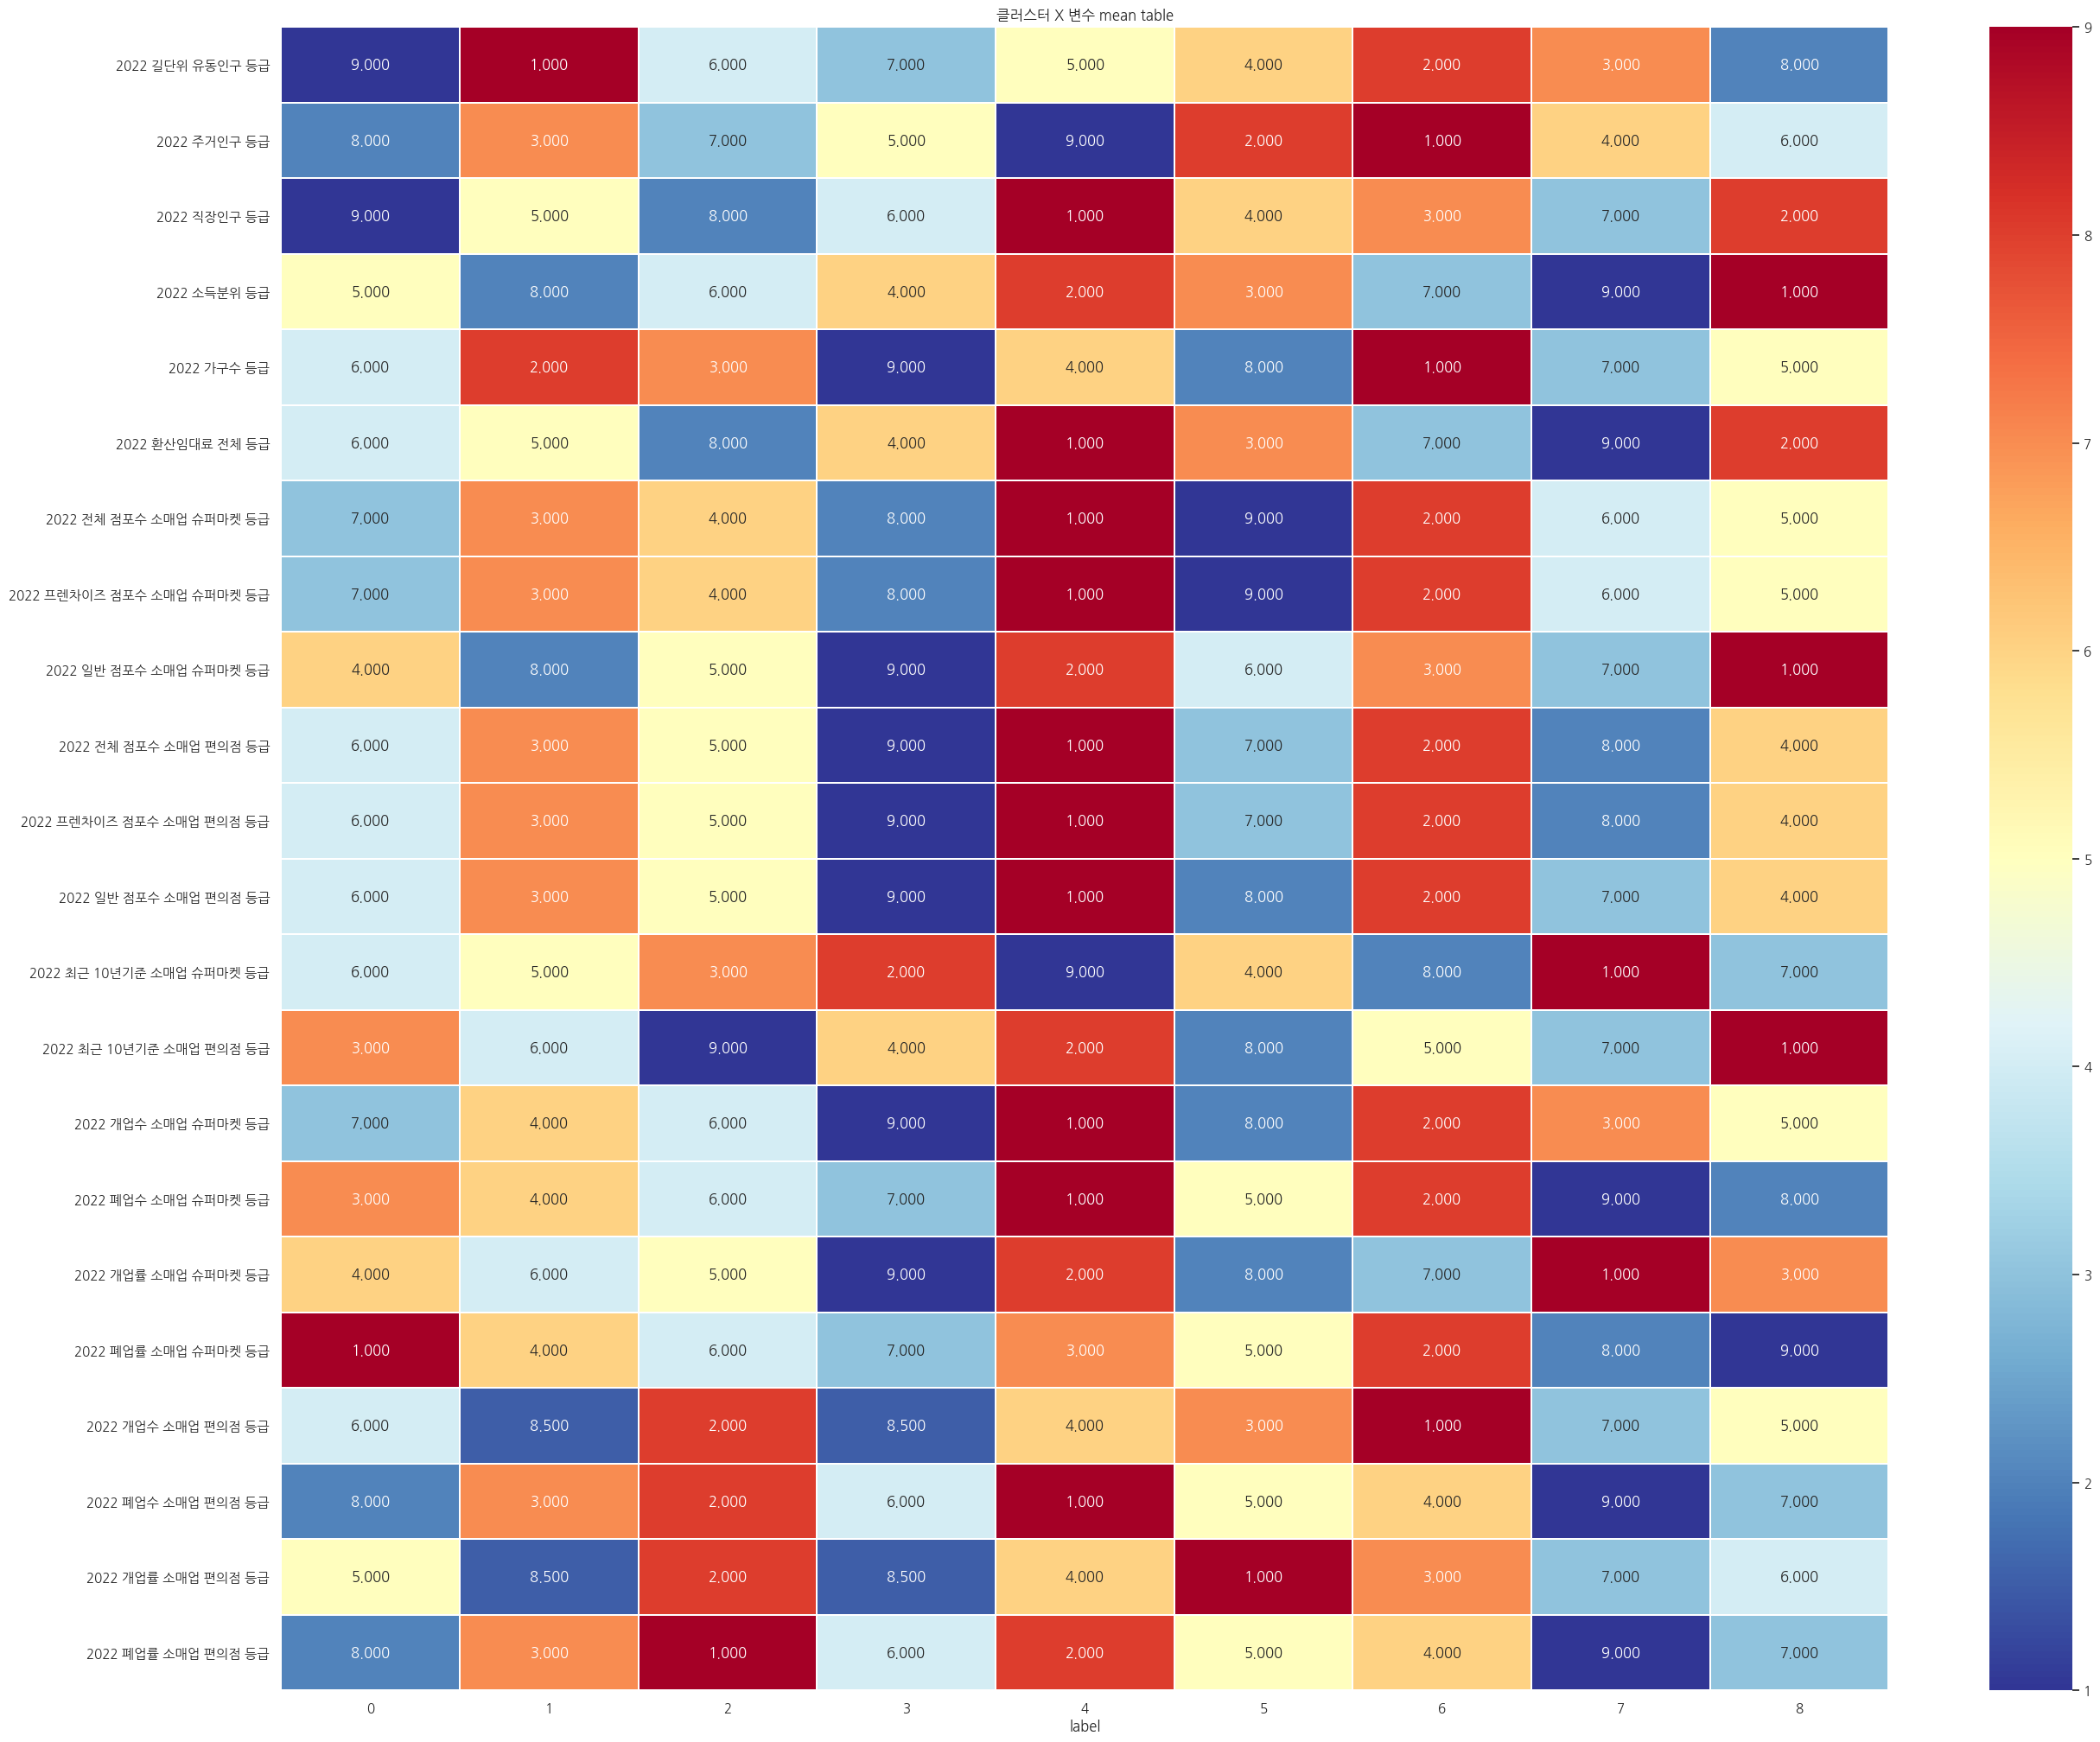

In [319]:
# 히트맵으로 그리기
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize = (30, 25))   
annot_kws= {'fontsize':12}   
sns.heatmap(mean.rank(axis=1,ascending=False),
            annot=mean.rank(axis=1),   
            fmt='.3f',     
            linewidths = 0.1,  
            annot_kws = annot_kws,   
            cmap = 'RdYlBu_r')   
plt.title('클러스터 X 변수 mean table', fontsize=13,fontproperties=fontprop)
plt.show()